# Trabalho de IA: MLP

- Fazer leitura dos dados testes
- Fazer o loop das épocas
- Conferir o backpropagation
- Testar com conj binários

Depois:
Otimização e análise
- Parada antecipada
- Rever o doc de especificação do trabalho para montar os gráficos
- Começar a guardar os pesos (e perguntar pra prof o porquê)

##Preparando o ambiente

In [2]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from graphviz import Digraph
import json


In [3]:
alfabeto = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

def letra_para_vetor(letra):
    """
    Transforma um caractere num vetor de 26 posições, no qual a posição da letra correspondente é 1 e o restante é -1.
    :param letra: Letra a ser transformada num vetor
    :return: Vetor binário de 26 posições
    """
    vetor = [-1] * 26
    pos_letra = alfabeto.index(letra)
    vetor[pos_letra] = 1

    return vetor

def vetor_para_letra(vetor):
    """
    Encontra a letra do alfabeto correspondente a um vetor de 26 posições.
    :param vetor: Vetor de 26 posições que representa uma letra do alfabeto.
    :return: Letra correspondente.
    """
    # Encontra a posição do maior valor no vetor
    maior_pos = np.argmax(vetor)

    # Encontra a letra correspondente no alfabeto
    letra = alfabeto[maior_pos]

    return letra

In [4]:
def ler_arq_imagens(nome_arq):
    """
    Lê o arquivo de imagens e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de imagens.

    Returns:
        np.ndarray: Array numpy contendo as imagens.
    """
    with open(nome_arq, 'r') as file:
        data = file.read().strip().split('\n')
    data = [list(map(int, filter(lambda x: x.strip(), line.split(',')))) for line in data if line.strip()]
    return np.array(data)

def ler_arq_classes(nome_arq):
    """
    Lê o arquivo de classes e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de classes.

    Returns:
        np.ndarray: Array numpy contendo as classes.
    """
    with open(nome_arq, 'r') as file:
        data = []
        for line in file:
            vetor_letra = letra_para_vetor(line[0])
            data.append(vetor_letra)
    return np.array(data)

In [30]:
def dividir_dados(entrada, classes, div_proportion=0.2):
    """
        Divide dois vetores de dados em uma determinada proporção (padrão: 80/20).

        Args:
            entrada (np.array): Vetor dos dados a serem divididos.
            classes (np.array): Classificação dos dados a serem dividos.
            div_proportion (float): Proporção da divisão dos dados (padrão: 20%)

        Returns:
            dados_primeira_parte (np.array): Vetor de dados da primeira parte da divisão.
            classes_primeira_parte (np.array): Vetor de classificação dos dados da primeira parte da divisão.
            dados_segunda_parte (np.array): Vetor de dados da segunda parte da divisão.
            classes_segunda_parte (np.array): Vetor de classificação dos dados da segunda parte da divisão.
        """
    # Embaralha os índices para os dados serem divididos de forma aleatória
    print(entrada.shape[0])
    print(classes.shape[0])
    indices = np.arange(entrada.shape[0])
    np.random.shuffle(indices)

    # Obtém o índice da separação dos dados
    indice_split = int(len(indices) * (1 - div_proportion))

    # Divide o vetor de indíce em duas partes
    primeira_parte = indices[:indice_split]
    segunda_parte = indices[indice_split:]
    
    # Define os vetores de cada parte
    dados_primeira_parte = entrada[primeira_parte]
    classes_primeira_parte = classes[primeira_parte]
    dados_segunda_parte = entrada[segunda_parte]
    classes_segunda_parte = classes[segunda_parte]

    return dados_primeira_parte, classes_primeira_parte, dados_segunda_parte, classes_segunda_parte


Funcao pra reconstruir imagens a partir do array de array


In [5]:
def reconstruct_image(row_index, image_array):
    """
    Reconstrói e plota uma imagem a partir do array numpy.

    Args:
        row_index (int): Índice da linha da imagem a ser reconstruída.
        image_array (np.ndarray): Array numpy contendo as imagens.
    """
    image_array = image_array[row_index]
    image_reshaped = np.reshape(image_array, (10, 12))

    plt.figure(figsize=(4, 3))
    plt.imshow(image_reshaped, cmap='gray')
    plt.colorbar()
    plt.show()

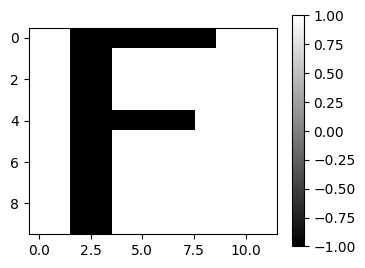

In [6]:
image = ler_arq_imagens('X.txt')
reconstruct_image(5,image)

In [7]:
# Funções de ativações para testes

def sigmoid(x, der=False):
    if der:
        fx = sigmoid(x)
        return fx * (1 - fx)
    return 1.0 / (1.0 + np.exp(-x))

def tanh(x, der=False):
    if der:
        return 1 - np.tanh(x) ** 2
    return np.tanh(x)

def relu(x, der=False):
    if der:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def leaky_relu(x, der=False):
    alpha = 0.01
    if der:
        return np.where(x > 0, 1, alpha)
    return np.where(x > 0, x, alpha * x)

def soft_max(x, der=False):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def activation_function(x, func, der=False):
    return func(x, der)

In [8]:
class Layer:
    def __init__(self, input_size, output_size, learning_rate, act_fun, output_layer=False):
        """
        Inicializa uma nova camada na rede neural.

        Args:
            input_size (int): Número de neurônios na camada anterior ou tamanho dos dados de entrada.
            output_size (int): Número de neurônios na camada atual.
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.
            act_fun (function): Função de ativação da camada.
            output_layer (bool): Booleano que indica se a camada é a de saída da MLP ou não.

        Attributes:
            weights (np.array): Matriz de pesos, onde cada peso conecta um neurônio de entrada a um neurônio de saída.
            biases (np.array): Vetor de biases, um para cada neurônio de saída.
            weighted_input (np.array): Armazena a entrada ponderada (antes da aplicação de qualquer função de ativação).
            output_data (np.array): Armazena a saída da camada, que neste caso é simplesmente a entrada ponderada.
            input_data (np.array): Armazena a entrada da camada antes da ponderação.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.act_fun = act_fun
        self.output_layer = output_layer
        self.weights = np.random.randn(input_size, output_size)  
        self.biases = np.random.randn(1, output_size) 
        self.weighted_input = None
        self.output_data = None
        self.input_data = None

    def forward(self, input_data):
        """
        Realiza o feed forward da camada.

        :param input_data: Vetor de dados de entrada.
        :return: Saída após multiplicação pelos pesos e função de ativação.
        """
        self.input_data = input_data
        self.weighted_input = np.dot(input_data, self.weights) + self.biases
        self.output_data = activation_function(self.weighted_input, self.act_fun)

        return self.output_data

    def backward(self, error):
        """
        Realiza o backward propagation da camada.

        :param error: Erros que serão usados para calcular a correção dos pesos.
        :return: Gradientes para serem usados na correção da camada abaixo.
        """
        # Caso não seja a camada de saída, multiplica o erro pela derivada da função de ativação sobre a entrada ponderada da camada.
        if not self.output_layer:
            error = error * activation_function(self.weighted_input, self.act_fun, True)

        if self.input_data.ndim == 1:
            self.input_data = self.input_data.reshape(1, -1)  # Garante que input_data é bidimensional
        if error.ndim == 1:
            error = error.reshape(1, -1)  # Garante que error é bidimensional

        # Calcula correções e gradientes
        input_error = np.dot(error, self.weights.T)
        weights_error = np.dot(self.input_data.T, error)

        # Atualiza pesos e biases
        self.weights += self.learning_rate * weights_error
        self.biases += self.learning_rate * np.sum(error, axis=0, keepdims=True)
        return input_error

In [9]:
class NeuralNetwork:
    def __init__(self, learning_rate):
        """
        Inicializa a rede neural com camadas especificadas.

        Args:
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.

        Attributes:
            learning_rate (float): Taxa de aprendizado da rede neural.
            hidden_layer1 (Layer): Primeira camada oculta da rede neural.
            hidden_layer2 (Layer): Segunda camada oculta da rede neural.
            output_layer (Layer): Camada de saída da rede neural.
            final_output (np.array): Armazena a saída final da rede após a propagação direta.
        """
        self.learning_rate = learning_rate
        self.hidden_layer1 = Layer(120, 80, self.learning_rate, sigmoid)
        self.hidden_layer2 = Layer(80, 50, self.learning_rate, sigmoid)
        self.output_layer = Layer(50, 26, self.learning_rate, leaky_relu, True)
        self.final_output = None

    def forward_propagation(self, input_data):
        """
        Realiza a propagação para frente através de toda a rede.

        Args:
            input_data (np.array): Dados de entrada para a rede.

        Returns:
            np.array: Saída final da rede.
        """
        output = self.hidden_layer1.forward(input_data)
        output = self.hidden_layer2.forward(output)
        self.final_output = self.output_layer.forward(output)
        return self.final_output

    def back_propagation(self, output_error):
        """
        Realiza a propagação para trás através de toda a rede.

        Args:
            output_error (np.array): Erro na saída da rede.
        """
        error = self.output_layer.backward(output_error)
        error = self.hidden_layer2.backward(error)
        self.hidden_layer1.backward(error)

    def save_weights(self, file_name):
        """
        Armazena os pesos das camadas num arquivo.

        Args:
            file_name (string): Nome do arquivo que irá armazenar os valores.
        """
        # Criando um dicionário para salvar os pesos de todas as camadas
        network = {
            # Conversão dos pesos da primeira camada oculta para uma lista
            'hidden_layer1': {'weights': self.hidden_layer1.weights.tolist(),
                            'biases': self.hidden_layer1.biases.tolist()},

            # Conversão dos pesos da segunda camada oculta para uma lista
            'hidden_layer2': {'weights': self.hidden_layer2.weights.tolist(),
                            'biases': self.hidden_layer2.biases.tolist()},

            # Conversão dos pesos da camada de saída para uma lista
            'output_layer': {'weights': self.output_layer.weights.tolist(),
                            'biases': self.output_layer.biases.tolist()}
        }

        # Abertura do arquivo para escrita
        with open(file_name, 'w') as f:
            # Salvando o dicionário no fomrato JSON
            json.dump(network, f) 

In [24]:
class MultilayerPerceptron:
    def __init__(self, min_output_error, max_epochs_num, early_stop_param):
        """
        Inicializa os parâmetros para o treinamento da rede neural.

        Args:
            min_output_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.
            early_stop_param (int): Número de épocas consecutivas com aumento do erro permitido antes da parada antecipada.

        Attributes:
            min_output_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.
            early_stop_param (int): Número de épocas consecutivas com aumento do erro permitido antes da parada antecipada.
            negative_error_var_num (int): Contador de épocas com aumento do erro.
            current_epoch_error (float): Taxa de erro da época atual.
            last_epoch_error (float): Taxa de erro da última época.
        """
        self.min_output_error = min_output_error
        self.max_epochs_num = max_epochs_num
        self.early_stop_param = early_stop_param
        self.negative_error_var_num = 0
        self.current_epoch_error = 0
        self.last_epoch_error = 0

        # Lista para armazenar os erros de treinamento em cada época
        self.training_errors = []

    def train(self, entrada, classes, neural_network):
        """
        Treina a rede neural usando o conjunto de dados de treinamento.

        Args:
            entrada (np.array): Dados de entrada para treinamento.
            classes (np.array): Labels correspondentes para o treinamento.
            neural_network (NeuralNetwork): Instância da rede neural a ser treinada.
        """
        # Divide os dados de entrada num conjunto de treinamento e outro de validação
        x_train, y_train, x_val, y_val = dividir_dados(entrada, classes)
        
        # Treina a MLP
        for epoch in range(self.max_epochs_num):
            epoch_error = 0

            # Loop que treina a MLP com os dados de treinamento
            for x, y in zip(x_train, y_train):
                output = neural_network.forward_propagation(x)
                output_error = y - output
                neural_network.back_propagation(output_error)
                epoch_error += np.mean(np.abs(output_error))

            self.training_errors.append(epoch_error)

            # Calcula a acurácia do modelo
            acuracia = self.get_accuracy(x_val, y_val, neural_network)

            # Printa erro e acurácia a cada dez épocas
            if epoch % 10 == 0:
                print(
                    f"Época {epoch}/{self.max_epochs_num}, Acurácia: {acuracia}, Erro: {epoch_error}")

            # Verifica parâmetros de early stop
            if epoch_error < self.min_output_error:
                print("Erro mínimo atingido. Parando o treinamento.")
                break
            
            # Verifica se o erro aumentou
            if epoch > 0 and self.training_errors[epoch] > self.training_errors[epoch - 1]:
                self.negative_error_var_num += 1
            else:
                self.negative_error_var_num = 0

            if self.negative_error_var_num >= self.early_stop_param:
                print("Parando antecipadamente devido ao aumento contínuo do erro.")
                break

        neural_network.save_weights("pesos_mlp.txt")
        return neural_network
    
    def get_accuracy(self, entrada, saida_esperada, neural_network):
        """
        Obtém a acurácia da rede neural passada como parâmetro.

        Args:
            entrada (np.array): Dados de entrada para teste.
            saida_esperada (np.array): Saída esperada da rede neural.
            neural_network (NeuralNetwork): Instância da rede neural treinada.

        Returns:
            acuracia (float): Porcentagem de acertos da rede.
        """

        # Inicializa variáveis para calcular acurácia
        num_testes = 0
        num_acertos = 0

        # Realiza teste para cada um dos dados de entrada
        for x, y in zip(entrada, saida_esperada):
            num_testes += 1
            
            # Realiza a predição
            predicao = neural_network.forward_propagation(x)

            # Obtém a letra predita pelo modelo
            letra_predita = vetor_para_letra(predicao)

            # Obtém a letra esperada
            letra_real = vetor_para_letra(y)

            if letra_predita == letra_real:
                num_acertos += 1
        
        acuracia = num_acertos / num_testes

        return acuracia

    def predict(self, entrada, neural_network):
        """
        Realiza predições usando a rede neural treinada.

        Args:
            entrada (np.array): Dados de entrada para teste.
            neural_network (NeuralNetwork): Instância da rede neural treinada.

        Returns:
            np.array: Predições da rede neural.
        """
        predictions = []
        for x in entrada:
            output = neural_network.forward_propagation(x)
            predictions.append(output)
        return np.array(predictions)

In [29]:
def main():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    # Dividindo os dados em conjuntos de treinamento e teste
    x_train, y_train, x_test, y_test = dividir_dados(imagens, classes)

    # Convertendo para float
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    # Inicializa a rede neural
    neural_network = NeuralNetwork(learning_rate=0.01)

    # Parâmetros para o treinamento
    min_output_error = 0.001
    max_epochs_num = 500
    early_stop_param = 100

    # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
    mlp = MultilayerPerceptron(min_output_error, max_epochs_num, early_stop_param)

    # Treina a rede neural
    mlp.train(x_train, y_train, neural_network)

    # Testa a rede neural
    predictions = mlp.predict(x_test, neural_network)

    # Exibe algumas predições para verificação
    num_testes = 0
    acertos = 0
    for i in range(20):
        num_testes += 1

        predicao = vetor_para_letra(predictions[i])
        correto = vetor_para_letra(y_test[i])

        if predicao == correto:
            acertos += 1
        print(f"Predição: {predicao}, Real: {correto}")

    print(f"Acurácia: {acertos/num_testes}")

In [31]:
main()

1326
1326
1060
1060
Época 0/500, Acurácia: 0.04245283018867924, Erro: 355.9382613212614
Época 10/500, Acurácia: 0.25, Erro: 124.66906310488099
Época 20/500, Acurácia: 0.4669811320754717, Erro: 120.60210718866276
Época 30/500, Acurácia: 0.589622641509434, Erro: 122.25907161245134
Época 40/500, Acurácia: 0.6556603773584906, Erro: 125.35855433723229
Época 50/500, Acurácia: 0.7358490566037735, Erro: 127.61766856420614
Época 60/500, Acurácia: 0.7358490566037735, Erro: 127.83908563903083
Época 70/500, Acurácia: 0.7688679245283019, Erro: 126.23770273751938
Época 80/500, Acurácia: 0.7924528301886793, Erro: 123.65869567302401
Época 90/500, Acurácia: 0.7924528301886793, Erro: 119.41443368565106
Época 100/500, Acurácia: 0.8066037735849056, Erro: 114.19506878671353
Época 110/500, Acurácia: 0.8018867924528302, Erro: 107.97161664543185
Época 120/500, Acurácia: 0.8018867924528302, Erro: 107.42385797779608
Época 130/500, Acurácia: 0.8160377358490566, Erro: 96.9514182442579
Época 140/500, Acurácia: 0.8

In [ ]:
from sklearn.model_selection import KFold

#Função para treinar a camada da arede neural
def train(layer, X_train, y_train, epochs):
    for epoch in range(epochs):
        for x, y in zip(X_train, y_train):
            layer.train(x, y)

#Função para valiar a camada da rede nneural nos dados de teste
def evaluate(layer, X_test, y_test):
    correct_predictions = 0
    for x, y_true in zip(X_test, y_test):
        y_pred = layer.forward_layers(x)
        if np.argmax(y_pred) == np.argmax(y_true):
            correct_predictions += 1
    accuracy = correct_predictions / len(X_test)
    return accuracy

#Função do Cross-validation
def cross_validation(layer_class, X, y, k=5, epochs=100, learning_rate=0.01):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Cria uma nova instância da camada para cada fold
        input_size = X.shape[1]
        output_size = y.shape[1]
        layer = layer_class(input_size, output_size, learning_rate)

        # Treina a camada
        train(layer, X_train, y_train, epochs)

        # Avalia a camada
        accuracy = evaluate(layer, X_test, y_test)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    return mean_accuracy


Exemplo de uso:

In [ ]:
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')
print(imagens.head())


In [ ]:
print(classes.head())

In [ ]:
# Executando o treinamento e teste da rede neural
mlp = MultilayerPerceptron()
mlp.main(imagens, classes)#

In [ ]:
# Plotando o erro de treinamento
plt.plot(mlp.training_errors)
plt.title('Erro de Treinamento por Época')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.grid(True)
plt.show()


In [ ]:
# Criação de uma tabela com os erros de treinamento
df_erros_treinamento = pd.DataFrame({
    'Época': range(len(mlp.training_errors)),
    'Erro': mlp.training_errors
})

# Exibindo a tabela
print(df_erros_treinamento)


Falta:

- fazer o erro parar de diminuir pouco
- tirar sklearn do cross-validation
- verificar se o gráfico tá gerando certo
- gerar matriz de confusão para testes da rede


# Roteiro para vídeo

V1:
- Parte de treinamento do código (com e sem validação cruzada e parada antecipada) PARA: conjunto de dados CARACTERES COMPLETO (os outros de teste não entram)
- Estudo dos parâmetros (busca por valores adequados – grid) (?)
- Teste da MLP para o conjunto de dados CARACTERES COMPLETO

V2:
- 
